# CIFAR-10 Demonstration

This notebook demonstrates how to use the `hierarchicalsoftmax` module to train a neural network on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. 

## Data

First we load the data using `torchvision` and create a `DataLoader` for the training and test sets. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.


In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = datasets.CIFAR10(root=".", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root=".", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

len(train_data), len(test_data)

(50000, 10000)

### Plot the first 10 images

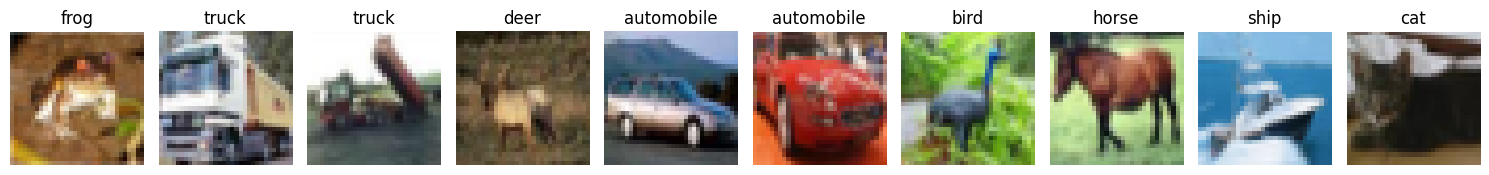

In [2]:
import matplotlib.pyplot as plt

num_images = 10
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))  # 1 row, 5 columns

for i in range(num_images):
    img, label = train_data[i]
    img = img.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)

    axes[i].imshow(img)
    axes[i].set_title(f"{train_data.classes[label]}")
    axes[i].axis('off')  # Remove axis ticks

plt.tight_layout()
plt.show()

## Non-hierarchical model

First we create a basic non-hierarchical model as a baseline

In [ ]:
import torch
from torch import nn
from torchmetrics import Accuracy
import lightning as L

def model_body():
    return nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Flatten(),
    )

class BasicImageClassifier(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            model_body(),
            nn.LazyLinear(out_features=len(train_data.classes))
        )
        self.loss_fn = nn.CrossEntropyLoss()
        self.metrics = [
            Accuracy(task="multiclass", num_classes=len(train_data.classes))
        ]

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        for metric in self.metrics:
            metric = metric.to(logits.device)
            result = metric(logits, y)
            if isinstance(result, dict):
                for name, value in result.items():
                    self.log(f"val_{name}", value, on_step=False, on_epoch=True, prog_bar=True)
            else:
                self.log(f"val_{metric.__class__.__name__}", result, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

model = BasicImageClassifier()

In [ ]:
trainer = L.Trainer(max_epochs=10, accelerator="auto", enable_checkpointing=False, logger=False])
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
W0512 20:20:36.861000 90235 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
/Users/rturnbull/MDAP/hierarchicalsoftmax/.venv/lib/python3.13/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:477: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ Sequential       │  388 K │ train │
│ 1 │ loss_fn │ CrossEntropyLoss │      0 │ train │
└───┴─────────┴──────────────────┴────────┴───────┘

Trainable params: 388 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 388 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 16                                                                                          
Modules in eval mode: 0

Output()

/Users/rturnbull/MDAP/hierarchicalsoftmax/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/d
ata_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.

/Users/rturnbull/MDAP/hierarchicalsoftmax/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/d
ata_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


## Hierarchical model

Let's now create a hierarchical model.
First we need to create a tree structure for the CIFAR-10 dataset.

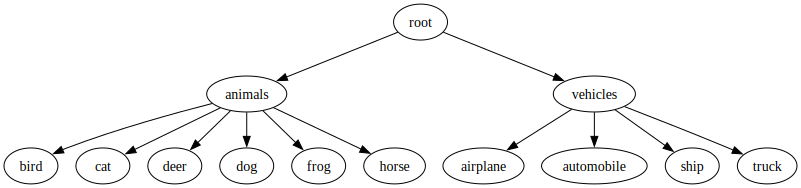

In [5]:
from hierarchicalsoftmax import (
    SoftmaxNode,
    HierarchicalSoftmaxLazyLinear,
    HierarchicalSoftmaxLoss,
)
from hierarchicalsoftmax.metrics import RankAccuracyTorchMetric

root = SoftmaxNode("root")
animals = SoftmaxNode("animals", parent=root)
vehicles = SoftmaxNode("vehicles", parent=root)

# Animal subclasses
SoftmaxNode("bird", parent=animals)
SoftmaxNode("cat", parent=animals)
SoftmaxNode("deer", parent=animals)
SoftmaxNode("dog", parent=animals)
SoftmaxNode("frog", parent=animals)
SoftmaxNode("horse", parent=animals)

# Vehicle subclasses
SoftmaxNode("airplane", parent=vehicles)
SoftmaxNode("automobile", parent=vehicles)
SoftmaxNode("ship", parent=vehicles)
SoftmaxNode("truck", parent=vehicles)

# Now that the tree is built, we can set the indexes
# This makes the tree read-only
root.set_indexes()
name_to_node_id = {node.name: root.node_to_id[node] for node in root.leaves}
index_to_node_id = {i: name_to_node_id[name] for i, name in enumerate(train_data.classes)}

# Render the hierarchy
root.graphviz()

### Create DataLoaders with hierarchical labels

In [6]:
class HierarchicalDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, index_to_node_id):
        self.dataset = dataset
        self.index_to_node_id = index_to_node_id

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, self.index_to_node_id[label]

    def __len__(self):
        return len(self.dataset)

batch_size = 64
hierarchical_train_loader = DataLoader(HierarchicalDataset(train_data, index_to_node_id), batch_size=batch_size, shuffle=True)
hierarchical_test_loader = DataLoader(HierarchicalDataset(test_data, index_to_node_id), batch_size=batch_size, shuffle=False)

### Create the Hierarchical Image Classifier model

In [ ]:
class HierarchicalImageClassifier(BasicImageClassifier):
    # Just overriding the init - keep the rest of the code
    def __init__(self, root: SoftmaxNode):
        super().__init__()
        self.model = nn.Sequential(
            model_body(),
            HierarchicalSoftmaxLazyLinear(root=root)
        )
        self.loss_fn = HierarchicalSoftmaxLoss(root)
        self.metrics = [
            RankAccuracyTorchMetric(
                root,
                {1: "superclass_accuracy", 2: "class_accuracy"},
            ),
        ]
        self.root = root

### Train the hierarchical model

In [26]:
from lightning.pytorch.loggers import CSVLogger

hierarchical_logger = CSVLogger(save_dir="lightning_logs", name="hierarchical_model")
hierarchical_trainer = L.Trainer(max_epochs=10, accelerator="auto", enable_checkpointing=False, logger=hierarchical_logger)
hierarchical_trainer.fit(HierarchicalImageClassifier(root), train_dataloaders=hierarchical_train_loader, val_dataloaders=hierarchical_test_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name    | Type                    | Params | Mode 
------------------------------------------------------------
0 | model   | Sequential              | 388 K  | train
1 | loss_fn | HierarchicalSoftmaxLoss | 0      | train
------------------------------------------------------------
388 K     Trainable params
0         Non-trainable params
388 K     Total params
1.554     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/rturnbull/MDAP/hierarchicalsoftmax/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/rturnbull/MDAP/hierarchicalsoftmax/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [28]:
import pandas as pd
from pathlib import Path
metrics_path = Path(hierarchical_logger.log_dir) / "metrics.csv"
metrics = pd.read_csv(metrics_path)
metrics

,epoch,step,train_loss,val_class_accuracy,val_loss,val_superclass_accuracy
0,0,49,1.779945,NaN,NaN,NaN
1,0,99,1.768242,NaN,NaN,NaN
2,0,149,1.549941,NaN,NaN,NaN
3,0,199,1.352020,NaN,NaN,NaN
4,0,249,1.583348,NaN,NaN,NaN
...,...,...,...,...,...,...
161,9,7649,0.162701,NaN,NaN,NaN
162,9,7699,0.292498,NaN,NaN,NaN
163,9,7749,0.132061,NaN,NaN,NaN
164,9,7799,0.226230,NaN,NaN,NaN
